# Loading the data

Importing the necessary libraries

In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
from scipy.io import wavfile
import seaborn as sns
from tensorflow.keras.layers import LSTM
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import noisereduce as nr
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
import tensorflow.keras as keras

Loading the audio files using librosa library.

In [2]:
# Loading normal
normal=os.listdir("heart_sound/heart_sound/train/healthy")[:650]

# Loading abnormal
abnormal=os.listdir("heart_sound/heart_sound/train/unhealthy")

In [3]:
normal_sounds=[]
normal_duration=[]
sample_rate=22050
for sound in normal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/heart_sound/train/healthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    normal_sounds.append(audio)
    normal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [4]:
normal_df= pd.DataFrame()
normal_df['audio']= normal_sounds
normal_df['class']= 0
normal_df['file_name']=normal
normal_df['duration']=normal_duration

In [5]:
abnormal_sounds=[]
abnormal_duration=[]
for sound in abnormal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/heart_sound/train/unhealthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    abnormal_sounds.append(audio)
    abnormal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [6]:
abnormal_df= pd.DataFrame()
abnormal_df['audio']= abnormal_sounds
abnormal_df['class']= 1
abnormal_df['file_name']=abnormal
abnormal_df['duration']=abnormal_duration

In [7]:
heart_sound= pd.concat([normal_df, abnormal_df], ignore_index=True, sort=False)

In [8]:
heart_sound.shape

(1315, 4)

In [9]:
heart_sound.head()

,audio,class,file_name,duration
0,"[0.0010432453, 0.0014091895, 0.0018182063, 0.0...",0,b0123.wav,8.000000
1,"[-0.090585805, -0.09565477, -0.099753596, -0.1...",0,e01947.wav,8.119002
2,"[-0.0010384485, -0.0014539795, -0.0018792074, ...",0,e00481.wav,17.966032
3,"[0.004732245, 0.0044500255, 0.0040681735, 0.00...",0,e00495.wav,15.101043
4,"[-0.012747022, -0.0134038385, -0.013926082, -0...",0,e01006.wav,20.381043


We have 4 features and 1315 observations. 

* Audio represents the audio files as a floating point time series.
  The audio file is already normalized, all data points are between 1 and -1.

* Class represents the heart's condition, 1 if the condition is abnormal and 0 if the condition is normal.

* File name represents the name of the audio file.

* Duration represents the duration of audio file in seconds.

# EDA

Checking the duration of the audio files.

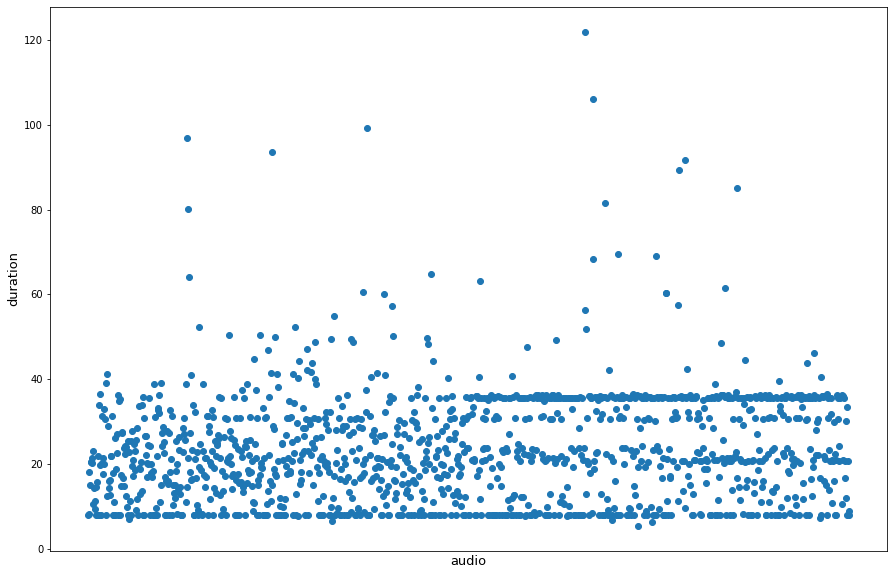

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
video = heart_sound['file_name']
duration = heart_sound['duration']
plt.xlabel("audio",fontsize=13);
plt.ylabel("duration",fontsize=13);
plt.xticks([])
plt.scatter(video,duration)
plt.show()

Dropping audio files of 40 seconds or more.

In [11]:
heart_sound=heart_sound[heart_sound['duration']<40]
heart_sound=heart_sound.reset_index(drop=True)

Visualizing class distribution

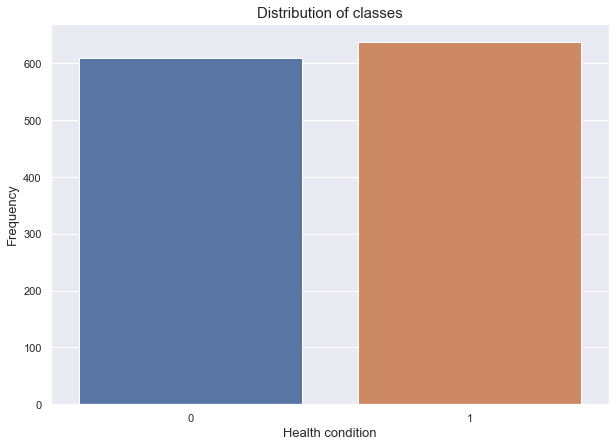

In [12]:
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="class",data=heart_sound);
ax.set_xlabel("Health condition",fontsize=13);
ax.set_ylabel("Frequency",fontsize=13);
ax.set_title('Distribution of classes',fontsize=15);
plt.savefig('images/Figure1.png', dpi=200)

The plot shows that the classes are balanced.

The waveplot shows the change in air pressure at a certain time.

The following plot is a waveplot for a normal heart sound.

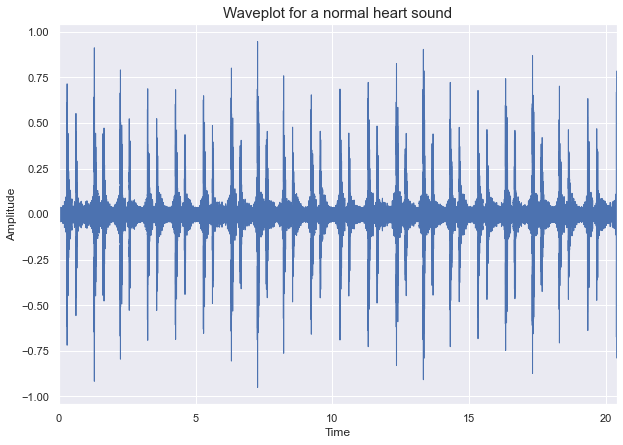

In [13]:
librosa.display.waveplot(heart_sound['audio'][4],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot for a normal heart sound', fontsize=15);

Play the audio directly in the notebook.

In [14]:
ipd.Audio(heart_sound['audio'][4],rate=sample_rate)

The following plot is a waveplot for an abnormal heart sound.

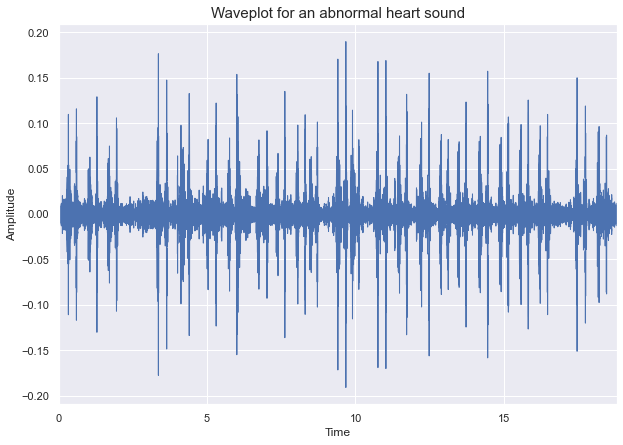

In [15]:
librosa.display.waveplot(heart_sound['audio'][1002],sr=sample_rate);
plt.ylabel("Amplitude")
plt.title('Waveplot for an abnormal heart sound', fontsize=15);

Play the audio directly in the notebook.

In [16]:
ipd.Audio(heart_sound['audio'][1002],rate=sample_rate)

**Spectrograms**

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

STFT converts signals such that we can know the amplitude of the given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal. specshow is used to display a spectrogram.

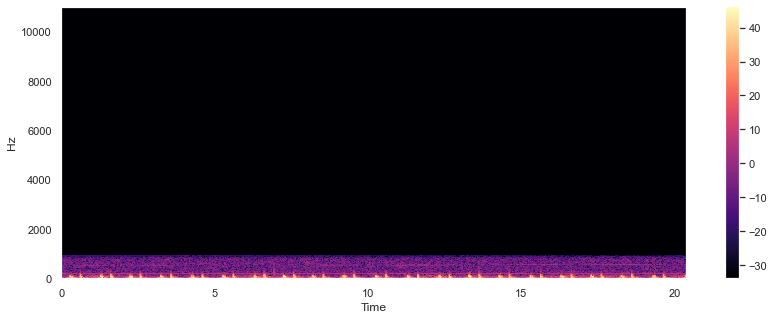

In [17]:
# audio file chosen randomly from the dataset
X = librosa.stft(heart_sound['audio'][4])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') 
plt.colorbar();

We see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

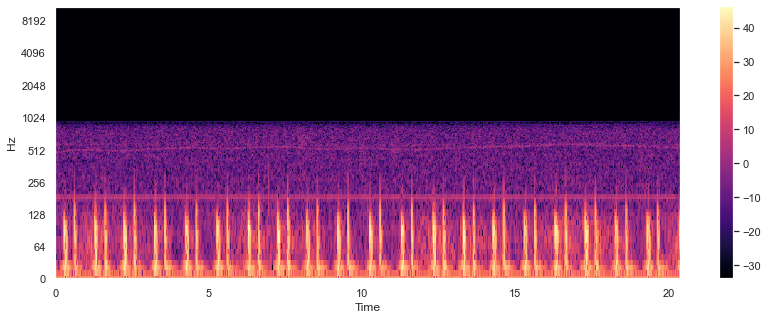

In [18]:
X = librosa.stft(heart_sound['audio'][4]) #fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log') 
plt.colorbar();

A Mel spectrogram is a spectrogram where the frequencies are converted to the Mel scale, which is a logarithmic transformation of a signal's frequency. We used melspectrogram from Librosa with the default sampling rate and 2048 length of the FFT window.

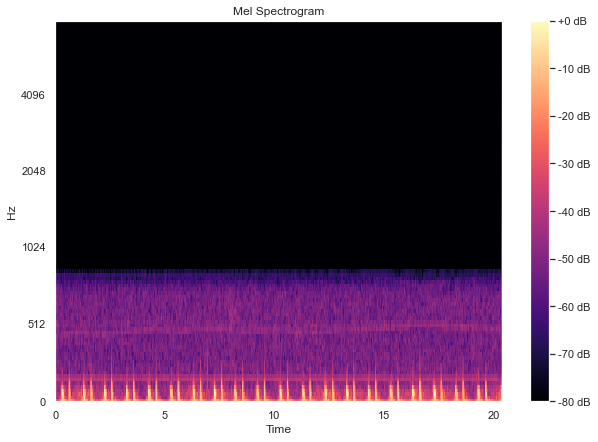

In [19]:
mel_spect = librosa.feature.melspectrogram(y=heart_sound['audio'][4], sr=22050, n_fft=2048, hop_length=512)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

### Determine the most relevant classification metric

Given the model's use case, we are interested in calculating the recall. Because it represents the measure of how well the classifier detects cases of people that do have abnormal heartbeats. In terms of probabilities, it can be formulated as: “the probability that a sick patient is detected by the classifier”.

### Classification Baseline

The chosen baseline model is **K-Nearest Neighbors**.

Extracting the features.

In [20]:
def features_extractor(audio, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [22]:
extracted_features=[]
for audio in heart_sound['audio']:
        data=features_extractor(audio,sample_rate)
        extracted_features.append(data)

In [23]:
heart_sound['extracted_features']=extracted_features

In [27]:
x=np.array(heart_sound['extracted_features'].tolist())
y=np.array(heart_sound['class'].tolist())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=70)

In [29]:
y_pred=knn.predict(X_test)
recall_score(y_test, y_pred, average='macro')

0.6998207885304659

It achieved recall of 0.6998

### Preprocessing

Removing the noise from the audio files.

In [30]:
def reducenoise(audio):
    return nr.reduce_noise(y=audio, sr=sample_rate)

In [31]:
heart_sound['audio']=heart_sound['audio'].apply(lambda x:reducenoise(x))

Making all audio files the same length

In [32]:
max1 = len(heart_sound['audio'][0])
for i in range(len(heart_sound)):
    if max1< len(heart_sound['audio'][i]):
        max1=len(heart_sound['audio'][i])

In [33]:
audio_padded=[]
for i in range(len(heart_sound)):
    n=max1-len(heart_sound['audio'][i])
    newdf=np.pad(heart_sound['audio'][i],(0,n),'constant')
    audio_padded.append(newdf)

In [34]:
heart_sound['audio_padded']=audio_padded

# Neural Networks

We will try 3 neural networks to see which one gives the best performance.
- Feedforward neural network.
- LSTM neural network.
- CNN neural network.

## Feedforward Neual Network

Extracting features

In [35]:
extracted_features=[]
for audio in heart_sound['audio']:
        data=features_extractor(audio,sample_rate)
        extracted_features.append(data)

In [36]:
heart_sound['extracted_features']=extracted_features

In [65]:
x=np.array(heart_sound['extracted_features'].tolist())
y=np.array(heart_sound['class'].tolist())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

Building the network which consists of an input layer, 2 hidden layers and an output layer.

In [66]:
ann_model=Sequential()

ann_model.add(Dense(100,input_shape=(40,)))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(100))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(1))
ann_model.add(Activation('sigmoid'))
ann_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               4100      
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [67]:
ann_model.compile(loss='binary_crossentropy',metrics=['Recall'],optimizer='adam')

In [68]:
num_epochs = 40
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification1.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

history_ann=ann_model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40
 1/28 [>.............................] - ETA: 14s - loss: 0.7482 - recall: 0.6111
Epoch 00001: val_loss improved from inf to 0.73353, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 1s 9ms/step - loss: 0.8519 - recall: 0.5122 - val_loss: 0.7335 - val_recall: 1.0000
Epoch 2/40
 1/28 [>.............................] - ETA: 0s - loss: 0.9054 - recall: 0.7368
Epoch 00002: val_loss improved from 0.73353 to 0.72313, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 0s 3ms/step - loss: 0.8692 - recall: 0.5033 - val_loss: 0.7231 - val_recall: 1.0000
Epoch 3/40
 1/28 [>.............................] - ETA: 0s - loss: 0.7901 - recall: 0.8889
Epoch 00003: val_loss improved from 0.72313 to 0.62238, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 0s 3ms/step - loss: 0.7984 - recall: 0.5924 - val_loss: 0.6224 - val_recall: 0.7037
Epoch 4/40
 1/28

In [69]:
score= ann_model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.4849853813648224
Test recall: 0.9444444179534912


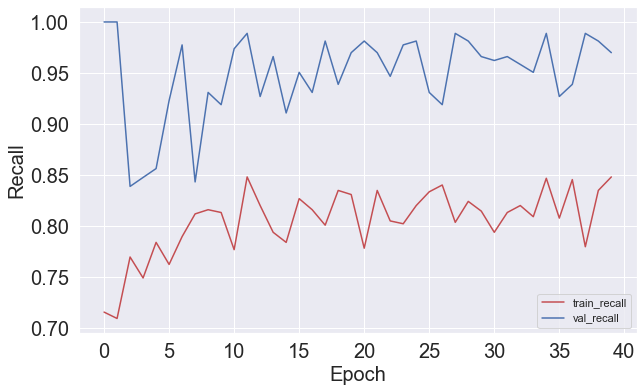

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(history_ann.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

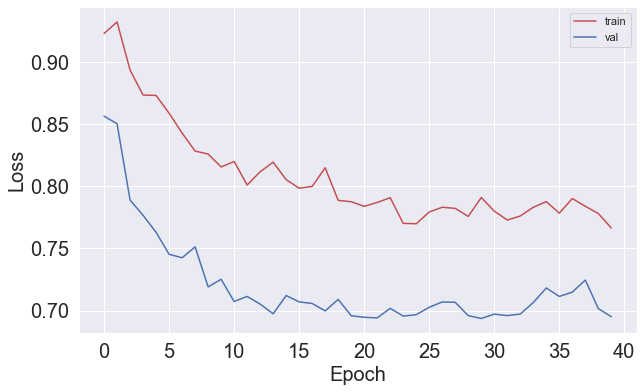

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history_ann.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

Feedforward neural network achieved recall of 0.94 on the test set.

## LSTM Neural Network

Extracting features for LSTM neural network.

In [44]:
mfcc_abnormal={'mfcc':[]}
samples_per_track = sample_rate * 40
num_segment=40
hop_length=512
samples_per_segment = int(samples_per_track / num_segment)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

heart_sound_ab=heart_sound[heart_sound['class']==1]
for sound in heart_sound_ab['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_abnormal['mfcc'].append(mfcc.tolist())  

abnormal_features=pd.DataFrame.from_dict(mfcc_abnormal)
abnormal_features['class']=1

In [45]:
mfcc_normal={'mfcc':[]}
heart_sound_an=heart_sound[heart_sound['class']==0]
for sound in heart_sound_an['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_normal['mfcc'].append(mfcc.tolist())  

normal_features=pd.DataFrame.from_dict(mfcc_normal)
normal_features['class']=0

In [46]:
heart_sound_LSTM= pd.concat([abnormal_features, normal_features], ignore_index=True, sort=False)

In [47]:
X2=np.array(heart_sound_LSTM['mfcc'].tolist())
y2=np.array(heart_sound_LSTM['class'].tolist())

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=42)

In [49]:
input_shape = (X_train2.shape[1],X_train2.shape[2])

Building the network which consists of an input layer, 3 hidden layers and an output layer.

In [56]:
lstm_model=Sequential()
lstm_model.add(keras.layers.LSTM(64,input_shape = (input_shape), return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))
lstm_model.add(keras.layers.Dropout(0.3))
lstm_model.add(keras.layers.Dense(128, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 44, 64)            19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 61,441
Trainable params: 61,441
Non-trai

In [57]:
lstm_model.compile(loss='binary_crossentropy',metrics=['Recall'],optimizer='sgd')

In [58]:
num_epochs = 20
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5',
                               verbose=1, save_best_only=True)

start = datetime.now()
lstm_history=lstm_model.fit(X_train2, y_train2, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2, y_val2), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
1215/1216 [============================>.] - ETA: 0s - loss: 0.6907 - recall: 0.6787
Epoch 00001: val_loss improved from inf to 0.69379, saving model to saved_models/audio_classification2.hdf5
1216/1216 [==============================] - 53s 41ms/step - loss: 0.6907 - recall: 0.6789 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 2/20
1216/1216 [==============================] - ETA: 0s - loss: 0.6882 - recall: 0.6429
Epoch 00002: val_loss improved from 0.69379 to 0.68075, saving model to saved_models/audio_classification2.hdf5
1216/1216 [==============================] - 51s 42ms/step - loss: 0.6882 - recall: 0.6429 - val_loss: 0.6808 - val_recall: 0.5822
Epoch 3/20
1215/1216 [============================>.] - ETA: 0s - loss: 0.6906 - recall: 0.6759
Epoch 00003: val_loss did not improve from 0.68075
1216/1216 [==============================] - 52s 42ms/step - loss: 0.6906 - recall: 0.6759 - val_loss: 0.6895 - val_recall: 0.9864
Epoch 4/20
1215/1216 [==========================

In [59]:
score = lstm_model.evaluate(X_test2,y_test2, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.6529991030693054
Test recall: 0.9620048403739929


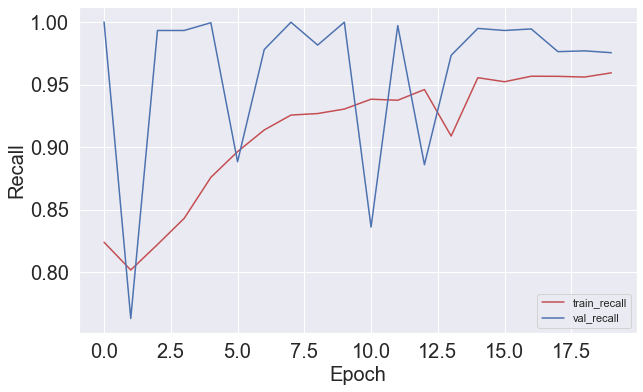

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lstm_history.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(lstm_history.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

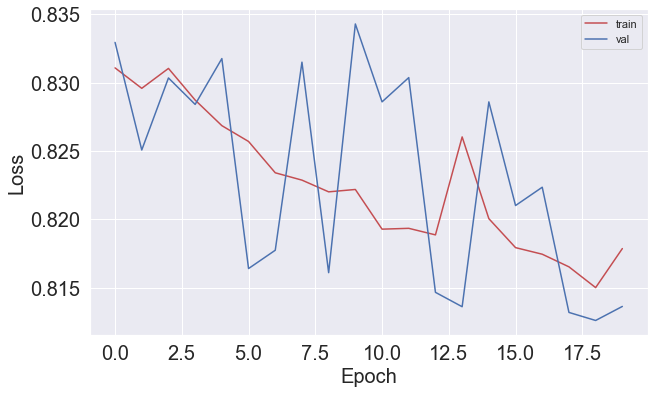

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lstm_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lstm_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

LSTM neural network achieved recall of 0.96 on the test set.

## CNN Neural Network

Defining a function that extracts the frame from .wav file.

In [91]:
INPUT_DIR ="heart_sound/"
OUTPUT_DIR = 'spectograms/'

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

Loading the audio files from 2 class and convert it to speccgram images.

In [92]:
cls=0

for dirr in os.listdir(INPUT_DIR):
    c=1
    print(dirr)
    for filename in os.listdir(INPUT_DIR+dirr+"/"):
        if "wav" in filename:
            if c == 650:
                break
            c+=1
            file_path = os.path.join(INPUT_DIR+dirr+"", filename)
            file_stem = Path(file_path).stem
            target_dir = "class_"+str(cls)
            dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(file_dist_path + '.png'):
                if not os.path.exists(dist_dir):
                    os.mkdir(dist_dir)
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                pylab.specgram(sound_info, Fs=frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
    cls+=1
# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(2):
    print(path_list[i])
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

heart_sound
Classes: 

class_0
class_1

A few example files: 

e01661.png
a0122.png
b0022.png
e01846.png
a0320.png
a0308.png
c0027.png
b0208.png
b0397.png
a0254.png


using image_dataset_from_directory to generates train and validation  tf.data.Dataset from image files in the 'audio-images' directory.

In [93]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10
# Make a dataset containing the training spectrograms
train_dataset = keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.35,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)
# Make a dataset containing the validation spectrogram
valid_dataset = keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.35,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)


Found 1298 files belonging to 2 classes.
Using 844 files for training.
Found 1298 files belonging to 2 classes.
Using 454 files for validation.


Ploting a sample of the spectrograms.

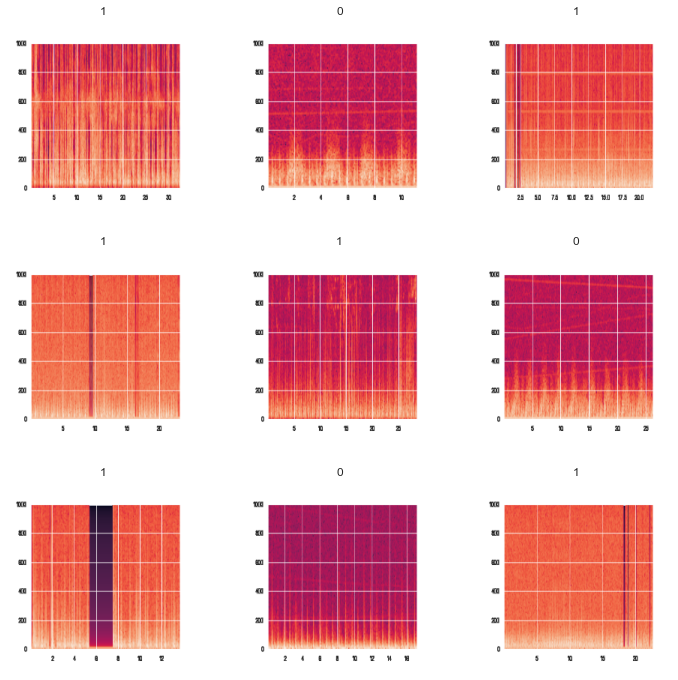

In [94]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [95]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = keras.Sequential([keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds
train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [118]:
# Create CNN model
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
#1st layer
model.add(keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
#2d array
model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
#2d layer
#model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
##model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.3))
#3d layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [119]:
# Compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['Recall'])

In [123]:
results = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
27/27 [==============================] - 38s 1s/step - loss: 0.5455 - recall: 0.6675 - val_loss: 0.6021 - val_recall: 0.5316
Epoch 2/10
27/27 [==============================] - 43s 2s/step - loss: 0.5006 - recall: 0.6942 - val_loss: 0.6139 - val_recall: 0.5696
Epoch 3/10
27/27 [==============================] - 44s 2s/step - loss: 0.4907 - recall: 0.7524 - val_loss: 0.5821 - val_recall: 0.7426
Epoch 4/10
27/27 [==============================] - 43s 2s/step - loss: 0.4479 - recall: 0.8058 - val_loss: 0.5791 - val_recall: 0.6667
Epoch 5/10
27/27 [==============================] - 44s 2s/step - loss: 0.4193 - recall: 0.8010 - val_loss: 0.5745 - val_recall: 0.6371
Epoch 6/10
27/27 [==============================] - 44s 2s/step - loss: 0.4321 - recall: 0.8155 - val_loss: 0.6368 - val_recall: 0.6076
Epoch 7/10
27/27 [==============================] - 43s 2s/step - loss: 0.3937 - recall: 0.8252 - val_loss: 0.5737 - val_recall: 0.6329
Epoch 8/10
27/27 [==============================

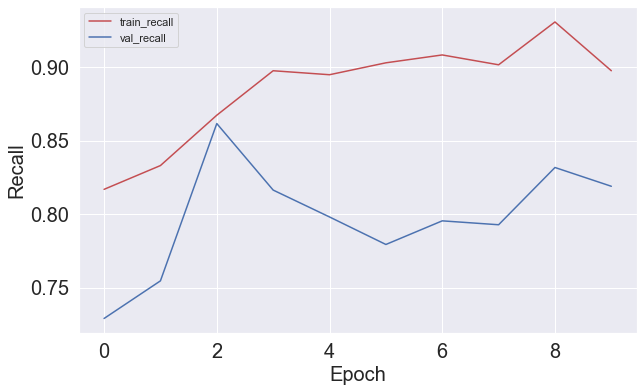

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(results.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(results.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

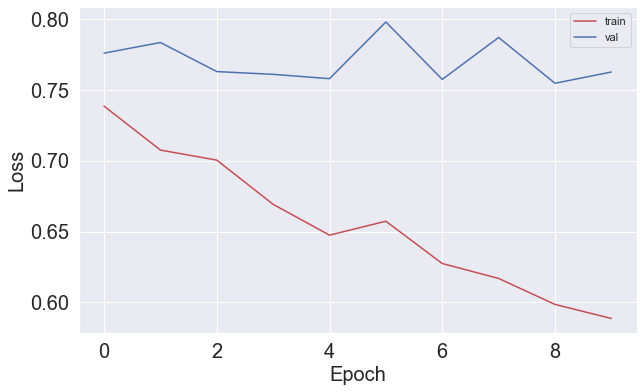

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(results.history['loss']), 'r', label='train')
ax.plot(np.sqrt(results.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Hyperparameter tuning for Feed Forwrd Neural Network Model

Now we are trying to improve the neural netwerok performance by tuning the hyperparameters which are:

- The number of nodes in layers
- Dropout rate
- Batch size
- Epochs to train for

In [52]:
# create function that returns a model
def get_mlp_model(hiddenLayerOne=100, hiddenLayerTwo=100, dropout=0.5):

    model = Sequential()
    model.add(Flatten())
    
    # add three stacks of FC => RELU => DROPOUT
    model.add(Dense(hiddenLayerOne, activation="tanh",input_shape=(40,)))
    model.add(Dropout(dropout))
    
    model.add(Dense(hiddenLayerTwo, activation="tanh"))
    model.add(Dropout(dropout))
    
    # add a sigmoid layer on top
    model.add(Dense(1, activation="sigmoid"))
    # compile the model
    model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["Recall"])
    # return compiled model
    return model

In [81]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [32,64, 100,128,256]
hiddenLayerTwo = [32,64, 100,128,256]
dropout = [0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32]
epochs = [10, 20, 30, 40]

# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    hiddenLayerTwo=hiddenLayerTwo,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs
)
model = KerasClassifier(build_fn=get_mlp_model, verbose=0)

In [85]:
# initialize a random search with a 3-fold cross-validation and then
# start the hyperparameter search process
print("[INFO] performing grid search...")
searcher = GridSearchCV(estimator=model, n_jobs=-1, verbose=10, cv=3,
    param_grid=grid, scoring="recall")
searchResults = searcher.fit(X_train, y_train)
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

[INFO] performing grid search...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[INFO] best score is 1.00 using {'batch_size': 4, 'dropout': 0.3, 'epochs': 20, 'hiddenLayerOne': 100, 'hiddenLayerTwo': 32}


In [86]:
ann_model =  get_mlp_model(100,32,0.3)

In [87]:
num_epochs = 20
num_batch_size = 4
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification1.hdf5', verbose=1, save_best_only=True)
history_ann=ann_model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)

Epoch 1/20
198/218 [==========================>...] - ETA: 0s - loss: 0.7936 - recall: 0.5381
Epoch 00001: val_loss improved from inf to 0.67747, saving model to saved_models/audio_classification1.hdf5
218/218 [==============================] - 2s 2ms/step - loss: 0.7973 - recall: 0.5278 - val_loss: 0.6775 - val_recall: 1.0000
Epoch 2/20
207/218 [===========================>..] - ETA: 0s - loss: 0.7309 - recall: 0.6023
Epoch 00002: val_loss did not improve from 0.67747
218/218 [==============================] - 0s 1ms/step - loss: 0.7358 - recall: 0.5902 - val_loss: 0.7368 - val_recall: 0.0222
Epoch 3/20
205/218 [===========================>..] - ETA: 0s - loss: 0.7608 - recall: 0.5359
Epoch 00003: val_loss improved from 0.67747 to 0.59867, saving model to saved_models/audio_classification1.hdf5
218/218 [==============================] - 0s 1ms/step - loss: 0.7538 - recall: 0.5546 - val_loss: 0.5987 - val_recall: 0.9926
Epoch 4/20
204/218 [===========================>..] - ETA: 0s - lo

In [88]:
score= ann_model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.44912484288215637
Test recall: 0.9629629850387573


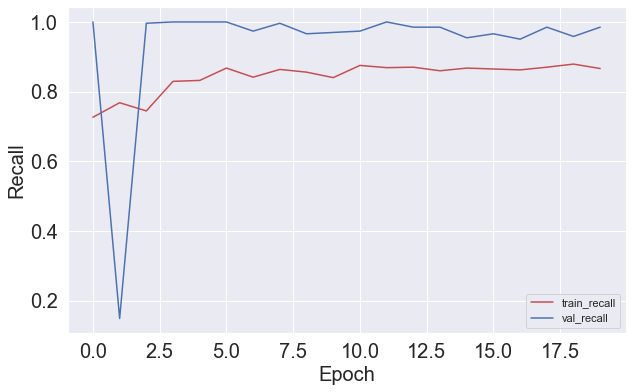

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(history_ann.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Recall', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

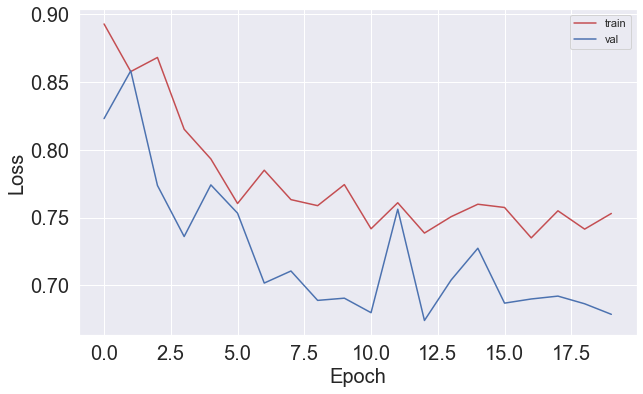

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history_ann.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history_ann.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

After tuning the hyperparameters of the feedforward neural network, the test recall raised from 0.94 to 0.96.

# Conclusion

In conclusion, LSTM neural network model has the best performance on classifying heart conditions through audio. While the feed-forward neural network model provides high recall, it suffers from overfitting. We can see that the validation recall of the feed-forward model is always close to one, which indicates that the model is not learning. On the other hand, CNN performed poorly because it's designed to work effectively on images.

**References**

- https://www.section.io/engineering-education/machine-learning-for-audio-classification/
- https://librosa.org/doc/main/auto_examples/plot_display.html
- https://www.servomagazine.com/magazine/article/music-genre-classification-using-lstm
- https://www.kaggle.com/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
- https://www.pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/